In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy import special
from scipy.optimize import fsolve

from tqdm.auto import tqdm
from scipy.sparse import coo_matrix, kron
from scipy.linalg import norm

# Advection Equation

## Periodic Boundary Condition
\begin{equation}\displaystyle
    \begin{cases}
        u_t - u_{xx} = 0, \text{ for } x\in [0,L], t\geq 0, \\
        u(0+x,t)=u(L+x,t)=0, t\geq 0, \\
        u(x,0)=f(x), \text{ for } x\in[0,L].
    \end{cases}
\end{equation}

## Dirichlet 
\begin{equation}\displaystyle
    \begin{cases}
        u_t - u_{xx} = 0, \text{ for } x\in [0,L], t\geq 0, \\
        u(x,t)=u(x,t)=0, t\geq 0, \\
        u(x,0)=f(x), \text{ for } x\in[0,L].
    \end{cases}
\end{equation}


## Neumann 
\begin{equation}\displaystyle
    \begin{cases}
        u_t - u_{xx} = 0, \text{ for } x\in [0,L], t\geq 0, \\
        u_x(x,t)=u_x(x,t)=0, t\geq 0, \\
        u(x,0)=f(x), \text{ for } x\in[0,L].
    \end{cases}
\end{equation}

In [44]:
class ForwardAdvectionEquation1D:
    # Forward time central space advcection equation
    # conditional stable
    def __init__(self, x_left, x_right, t_left, t_right,
                 Nx, Nt, bdy_cond):
        self.x_left = x_left
        self.x_right = x_right
        self.t_left = t_left
        self.t_right = t_right
        self.step_h = 1 / (Nx-1)
        self.step_t = 1 / (Nt-1)
        self.bdy_cond = bdy_cond
        
        self.step_ratio = self.step_t / (self.step_h**2)
        assert self.bdy_cond in ["Periodic", "Dirichlet",  "Neumann"], " The boundary conditions is not allowed."
        
        if(self.checkStability()):
            self.setMatrix(Nx-1)
        else:
            print("nonstable step ratio")
            return
        
    def checkStability(self):
        if self.step_ratio <= 1/2:
            # stable
            return True
        else:
            # nonstable
            return False

    def setMatrix(self, N):
        # linear system of of spatial nodes of each time step
        if self.bdy_cond == "Periodic":
            # x0, x1, x2, ... , x_{n-1}
            row = np.arange(1, N)
            col = np.arange(0, N-1)
            data = self.step_ratio * np.ones(N-1)
            off_diag = coo_matrix((data, (row, col)), shape=(N, N))
            
            row = np.arange(0, N)
            col = np.arange(0, N)
            data = (1 - 2*self.step_ratio) * np.ones(N)
            diag = coo_matrix((data, (row, col)), shape=(N, N))
            bdy = coo_matrix(([self.step_ratio], ([0], [N-1])), shape=(N, N))
            
            off_diag = off_diag+off_diag.T
            bdy = bdy + bdy.T
            self.A = off_diag + diag + bdy 
        elif self.bdy_cond == "Dirichlet" or self.bdy_cond == "Neumann":
            return
        else:
            return

#     def setInitalCondition(self):
#         if self.bdy_cond == "Dirichlet":
#             return
    def solve(self, u):
        return self.A.dot(u)

In [45]:
x_left = 0
x_right = 1

t_left = 0
t_right = 10

Nx = pow(2,5) # number of spatial nodes
Nt = pow(2,12) # number of temporal nodes
step_h = (x_right-x_left)/(Nx-1)
step_t = (t_right-t_left)/(Nt-1)
max_iter = 2**5


x = np.linspace(x_left, x_right, Nx)[:-1] # spatial domain
t = np.linspace(t_left, t_right, Nt) # temporal domain

u0 = np.exp(-1/2 * (x/0.4)**2) # initial condition

# u_exact = np.exp(-1/2 * ((x-t)/0.4)**2)
u_exact = [np.exp(-1/2 * ((x-t_i)/0.4)**2) for t_i in t]

In [43]:
coo_matrix(([2], ([0], [2]), shape=(2,2))).todense()

SyntaxError: invalid syntax (2001527971.py, line 1)

In [46]:
AE = ForwardAdvectionEquation1D(x_left, x_right, t_left, t_right, Nx, Nt, "Periodic")

In [82]:
u_prev = u0
mass_list = []
history_u = []
for i in range(0, pow(2,10)):
    u = AE.solve(u_prev)
    mass_list.append(abs(sum(u0-u)))
    u_prev = u
    history_u.append(u_prev)

<Figure size 432x288 with 0 Axes>

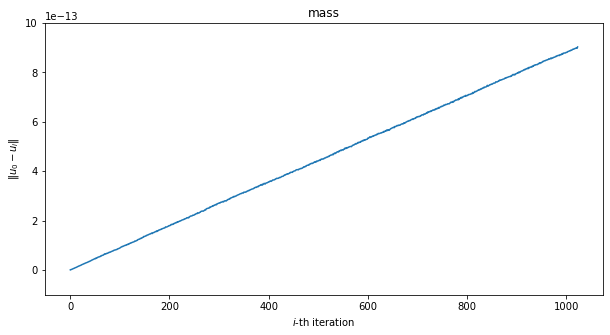

In [92]:
plt.figure(1)
plt.figure(figsize=(10,5))
plt.plot(mass_list)
plt.title("mass")
plt.ylabel("$\Vert u_0 - u_i \Vert$")
plt.xlabel("$i$-th iteration")
plt.ylim(-1e-13,1e-12)
plt.show()

In [421]:
def animate(i):
    line.set_data(history_u[i])
    return line,


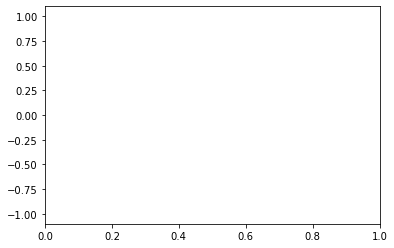

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [426]:
fig, ax = plt.subplots()
line,  = ax.plot(0, 0)
ax.set_xlim(0,1)
ax.set_ylim(-1.1,1.1)

ani = FuncAnimation(fig, animate, frames=len(history_u), interval=100)
plt.show()


from IPython.display import HTML
HTML(ani.to_html5_video())

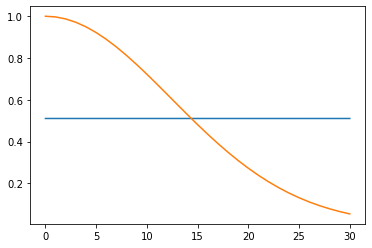

In [55]:
plt.plot(u)
plt.plot(u0)